In [1]:
#Import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn.model_selection as skl
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
import statsmodels.tools.tools as stattools

#Load data
esc_data = pd.read_csv(r"C:\Users\Kari\Documents\Data Science\Capstone\Eurovision Data.csv")
esc_data.head()

,Country,Artist,Song,Year,Semi,Qualified,Place,Order,Returning,Youtube,...,OGAE,Dance,Energy,Acoustic,Happy,Speech,Live,Loud,Tempo,Odds
0,Romania,Mandinga,Zaleilah,2012,1,1,3,6,0,7,...,52,70,82,5,79,5,34,-6,127,1.0
1,Ireland,Jedward,Waterline,2012,1,1,6,18,1,10,...,5,65,76,0,88,4,6,-5,144,1.0
2,Russia,Buranovskiye Babushiki,Party for Everybody,2012,1,1,1,14,0,1,...,42,66,85,19,62,13,35,-5,126,1.0
3,Greece,Eleftheria Eleftheriou,Aphrodisiac,2012,1,1,4,3,0,4,...,33,64,86,0,87,3,30,-5,110,1.0
4,Iceland,Greta Salome and Jonsi,Never Forget,2012,1,1,8,2,1,3,...,211,35,72,15,44,3,4,-4,135,1.0


In [2]:
#split data into training and testing
test_esc, train_esc = skl.train_test_split(esc_data, test_size = .67, random_state=1)

#split into x and y
#this y is for OLS Regression so it is the Place ranking
x = pd.DataFrame(train_esc[['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Loud','Tempo']])
y_place = pd.DataFrame(train_esc[['Place']])
x = sm.add_constant(x)

#Make the OLS model
model_ols = sm.OLS(y_place, x).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Place   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     17.04
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           9.85e-30
Time:                        13:04:26   Log-Likelihood:                -539.83
No. Observations:                 208   AIC:                             1116.
Df Residuals:                     190   BIC:                             1176.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1016      3.299     -0.031      0.975      -6.609       6.406
Order         -0.0200      0.050     -0.401      0.689      -0.118       0.078
Returning     -1.1032      0.680     -1.621      0.107      -2.445       0.239
Youtube        0.3368      0.064      5.301      0.000       0.211       0.462
Upvotes        0.0623      0.057      1.100      0.273      -0.049       0.174
Spotify        0.4353      0.071      6.119      0.000       0.295       0.576
English        0.0349      0.612      0.057      0.955      -1.173       1.243
Pop            0.1934      0.652      0.296      0.767      -1.093       1.480
Wiwibloggs    -0.2286      0.212     -1.080      0.281      -0.646       0.189
OGAE          -0.0030      0.003     -0.930      0.353      -0.009       0.003
Dance          0.0439      0.022      1.970      0.050    -6.5e-05       0.088
Energy         0.0026      0.025      0.104      0.918      -0.048       0.053
Acoustic      -0.0197      0.014     -1.453      0.148      -0.046       0.007
Happy          0.0049      0.017      0.294      0.769      -0.028       0.037
Speech         0.0156      0.090      0.173      0.863      -0.163       0.194
Live           0.0278      0.017      1.619      0.107      -0.006       0.062
Loud          -0.0480      0.149     -0.322      0.748      -0.342       0.246
Tempo          0.0007      0.010      0.077      0.938      -0.018       0.020
==============================================================================
Omnibus:                        0.927   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                1.013
Skew:                           0.092   Prob(JB):                        0.603
Kurtosis:                       2.712   Cond. No.                     2.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [3]:
#Make the x from the test data
x_test = pd.DataFrame(test_esc[['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Loud','Tempo']])
x_test = sm.add_constant(x_test)

#We are concerned with the qualification rather than actual Place rank
y_qualified_test = pd.DataFrame(test_esc[['Qualified']])

#Predict the y
ypred_ols = model_ols.predict(x_test)

#Categorize as qualified or non-qualified
ols_ypred = pd.DataFrame(ypred_ols, columns = ['Pred'])
ols_ypred['Pred1'] = np.where(ols_ypred['Pred']<= 10, 1, 0)

#print confusion matrix
confusion_matrix(y_qualified_test, ols_ypred['Pred1'])

array([[30, 11],
       [11, 50]], dtype=int64)

In [4]:
#create a reduced OLS regression model based on significant variables
x_2 = pd.DataFrame(train_esc[['Youtube','Spotify','Dance']])
x_2 = sm.add_constant(x_2)

#Run reduced OLS model
model_ols_red = sm.OLS(y_place, x_2).fit()
model_ols_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Place   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     90.55
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           2.73e-37
Time:                        13:04:41   Log-Likelihood:                -548.12
No. Observations:                 208   AIC:                             1104.
Df Residuals:                     204   BIC:                             1118.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.8365      1.215     -2.335      0.021      -5.232      -0.441
Youtube        0.3842      0.057      6.775      0.000       0.272       0.496
Spotify        0.5078      0.062      8.154      0.000       0.385       0.631
Dance          0.0700      0.018      3.975      0.000       0.035       0.105
==============================================================================
Omnibus:                        0.127   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.939   Jarque-Bera (JB):                0.252
Skew:                          -0.039   Prob(JB):                        0.881
Kurtosis:                       2.849   Cond. No.                         300.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [5]:
#create reduced test x
x_2_test = pd.DataFrame(test_esc[['Youtube','Spotify','Dance']])
x_2_test = sm.add_constant(x_2_test)

#predict the reduced model
ypred_ols_red = model_ols_red.predict(x_2_test)

#Categorize as qualified or non-qualified
ols_red_ypred = pd.DataFrame(ypred_ols_red, columns = ['Pred'])
ols_red_ypred['Pred1'] = np.where(ols_red_ypred['Pred']<= 10, 1, 0)

#print confusion matrix
confusion_matrix(y_qualified_test, ols_red_ypred['Pred1'])

array([[33,  8],
       [ 9, 52]], dtype=int64)

In [6]:
#Create new y variable as we want binary
y_qualified = pd.DataFrame(train_esc[['Qualified']])

#Create Logistic Regression Model
model_log = sm.Logit(y_qualified, x).fit(disp=0)
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  208
Model:                          Logit   Df Residuals:                      190
Method:                           MLE   Df Model:                           17
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                  0.4649
Time:                        13:04:48   Log-Likelihood:                -75.987
converged:                       True   LL-Null:                       -142.00
Covariance Type:            nonrobust   LLR p-value:                 7.607e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6922      3.062      1.859      0.063      -0.308      11.693
Order          0.0048      0.043      0.112      0.911      -0.079       0.089
Returning      0.5303      0.621      0.854      0.393      -0.687       1.747
Youtube       -0.1892      0.055     -3.451      0.001      -0.297      -0.082
Upvotes       -0.0713      0.052     -1.381      0.167      -0.172       0.030
Spotify       -0.3382      0.066     -5.138      0.000      -0.467      -0.209
English        0.2160      0.521      0.414      0.679      -0.805       1.237
Pop           -0.8294      0.610     -1.360      0.174      -2.025       0.366
Wiwibloggs     0.0809      0.198      0.409      0.683      -0.307       0.469
OGAE        3.444e-05      0.004      0.009      0.992      -0.007       0.007
Dance         -0.0166      0.019     -0.860      0.390      -0.054       0.021
Energy         0.0216      0.023      0.938      0.348      -0.023       0.067
Acoustic       0.0037      0.011      0.321      0.748      -0.019       0.026
Happy         -0.0169      0.014     -1.212      0.226      -0.044       0.010
Speech        -0.0391      0.074     -0.527      0.598      -0.185       0.106
Live          -0.0219      0.015     -1.444      0.149      -0.052       0.008
Loud          -0.0164      0.145     -0.114      0.909      -0.300       0.267
Tempo          0.0059      0.008      0.710      0.477      -0.010       0.022
==============================================================================
"""

In [7]:
#predict the y
ypred_log = model_log.predict(x_test)

#Categorize as qualified or non-qualified
log_ypred = pd.DataFrame(ypred_log, columns = ['Pred'])
log_ypred['Pred1'] = np.where(log_ypred['Pred']>= .5, 1, 0)

#print confusion matrix
confusion_matrix(y_qualified_test, log_ypred['Pred1'])

array([[32,  9],
       [13, 48]], dtype=int64)

In [8]:
#create a reduced logistic regression model based on significant variables
x_3 = pd.DataFrame(train_esc[['Youtube','Spotify']])
x_3 = sm.add_constant(x_3)

model_log_red = sm.Logit(y_qualified, x_3).fit(disp=0)
model_log_red.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Qualified   No. Observations:                  208
Model:                          Logit   Df Residuals:                      205
Method:                           MLE   Df Model:                            2
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                  0.4064
Time:                        13:04:53   Log-Likelihood:                -84.297
converged:                       True   LL-Null:                       -142.00
Covariance Type:            nonrobust   LLR p-value:                 8.674e-26
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9089      0.660      7.436      0.000       3.615       6.203
Youtube       -0.1898      0.045     -4.254      0.000      -0.277      -0.102
Spotify       -0.2950      0.053     -5.600      0.000      -0.398      -0.192
==============================================================================
"""

In [9]:
#create reduced test x
x_3_test = pd.DataFrame(test_esc[['Youtube','Spotify']])
x_3_test = sm.add_constant(x_3_test)

#predict the y
ypred_log_red = model_log_red.predict(x_3_test)

#Categorize as qualified or non-qualified
log_red_ypred = pd.DataFrame(ypred_log_red, columns = ['Pred'])
log_red_ypred['Pred1'] = np.where(log_red_ypred['Pred']>= .5, 1, 0)

#print confusion matrix
confusion_matrix(y_qualified_test, log_red_ypred['Pred1'])

array([[32,  9],
       [16, 45]], dtype=int64)

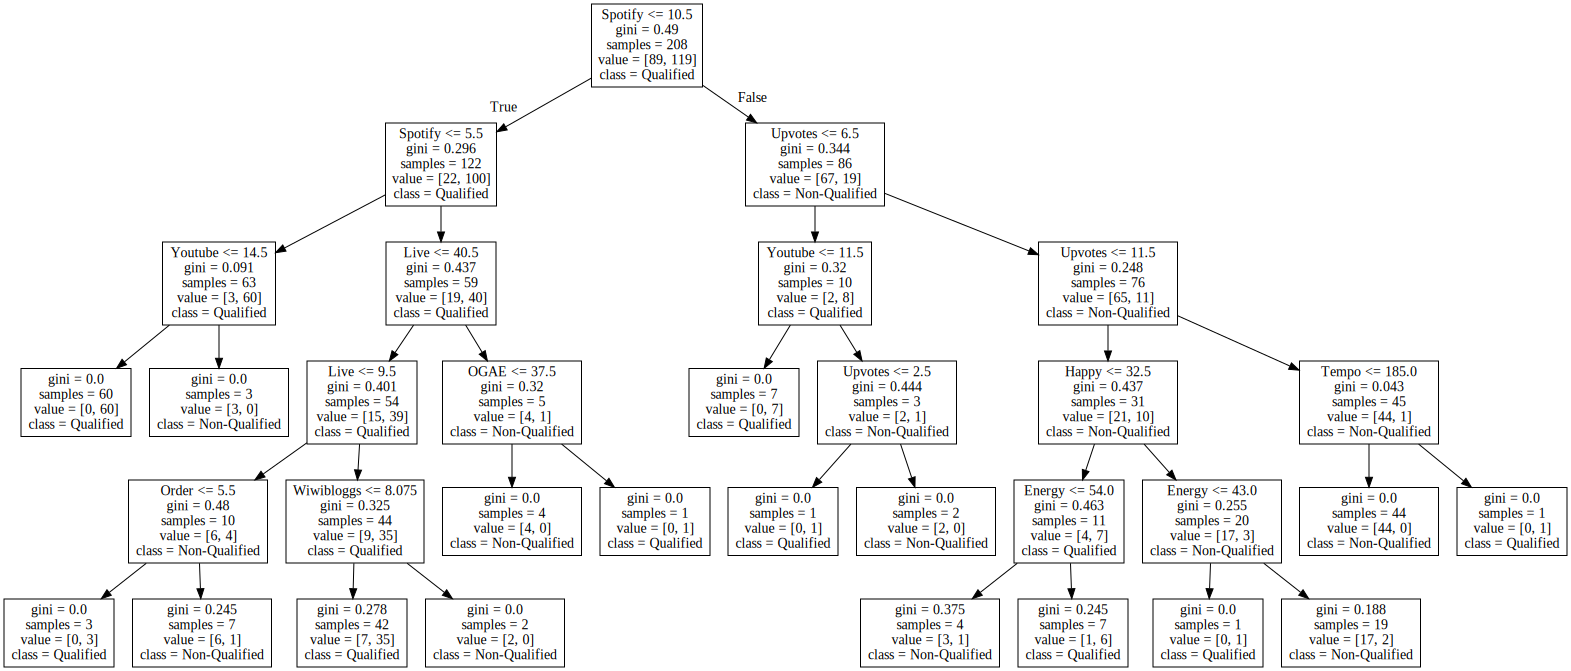

In [10]:
#create decision tree x
x_dec = pd.DataFrame(train_esc[['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Loud','Tempo']])

#create decision tree model
model_tree = DecisionTreeClassifier(max_depth=5).fit(x_dec,y_qualified.values.ravel())

#create labels
x_names = ['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Loud','Tempo']
y_names = ['Non-Qualified','Qualified']

# DOT data
dot_data = tree.export_graphviz(model_tree, out_file=None,feature_names=x_names,class_names=y_names)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [11]:
#create decision tree x
x_dec_test = pd.DataFrame(test_esc[['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Loud','Tempo']])

#get predictions
ypred_tree = model_tree.predict(x_dec_test)

#print confusion matrix
confusion_matrix(y_qualified_test, ypred_tree)


array([[30, 11],
       [19, 42]], dtype=int64)

In [12]:
#random forest model
model_rf = RandomForestRegressor(n_estimators=1000).fit(x_dec,y_qualified.values.ravel())

In [13]:
#get predictions
ypred_rf = model_rf.predict(x_dec_test)

#Categorize as qualified or non-qualified
rf_ypred = pd.DataFrame(ypred_rf, columns = ['Pred'])
rf_ypred['Pred1'] = np.where(rf_ypred['Pred']>= .5, 1, 0)

#print confusion matrix
confusion_matrix(y_qualified_test, rf_ypred['Pred1'])

array([[31, 10],
       [11, 50]], dtype=int64)

In [14]:
confusion_matrix(y_qualified_test, rf_ypred['Pred1']).ravel()
#tn,fp,fn,tp

array([31, 10, 11, 50], dtype=int64)

In [15]:
#cannot use negative values in naive bayes so remove Loud
x_nb = pd.DataFrame(train_esc[['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Tempo']])

#create naive bayes model
model_nb = MultinomialNB().fit(x_nb,y_qualified.values.ravel())

In [16]:
#cannot use negative values in naive bayes so remove Loud
x_nb_test = pd.DataFrame(test_esc[['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Tempo']])

#get y values
ypred_nb = model_nb.predict(x_nb_test)

#print confusion matrix
confusion_matrix(y_qualified_test, ypred_nb)

array([[37,  4],
       [36, 25]], dtype=int64)

In [17]:
#ensemble method
ensemble_pred = pd.DataFrame({
    'OLS': ols_ypred['Pred1'].values.ravel(),
    'OLS-Red': ols_red_ypred['Pred1'].values.ravel(),
    'Log' : log_ypred['Pred1'].values.ravel(),
    'Log-Red' : log_red_ypred['Pred1'].values.ravel(),
    'Tree' : ypred_tree,
    'RF' : rf_ypred['Pred1'].values.ravel(),
    'NB' : ypred_nb
})


ensemble_pred['Ensemble'] = np.where((ensemble_pred['OLS']+ensemble_pred['OLS-Red']+ensemble_pred['Log']+ensemble_pred['Log-Red']+ensemble_pred['Tree']+ensemble_pred['RF']+ensemble_pred['NB'])>= 4, 1, 0)
confusion_matrix(y_qualified_test, ensemble_pred['Ensemble'])

array([[35,  6],
       [11, 50]], dtype=int64)

In [18]:
def runmodels(year):
    #testing for year
    esc_year = esc_data
    esc_year = esc_year[(esc_year.Year == year)]

    #Make the x from the test data
    x_year = pd.DataFrame(esc_year[['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Loud','Tempo']])
    x_year = sm.add_constant(x_year)

    #We are concerned with the qualification rather than actual Place rank
    y_qualified_year = pd.DataFrame(esc_year[['Qualified']])

    #Predict the y
    ypred_ols_year = model_ols.predict(x_year)

    #Categorize as qualified or non-qualified
    ols_ypred_year = pd.DataFrame(ypred_ols_year, columns = ['Pred'])
    ols_ypred_year['Pred1'] = np.where(ols_ypred_year['Pred']<= 10, 1, 0)

    #print confusion matrix
    confusion_matrix(y_qualified_year, ols_ypred_year['Pred1'])
    
    #create reduced test x
    x_2_year = pd.DataFrame(esc_year[['Youtube','Spotify','Dance']])
    x_2_year = sm.add_constant(x_2_year)

    #predict the reduced model
    ypred_ols_red_year = model_ols_red.predict(x_2_year)

    #Categorize as qualified or non-qualified
    ols_red_ypred_year = pd.DataFrame(ypred_ols_red_year, columns = ['Pred'])
    ols_red_ypred_year['Pred1'] = np.where(ols_red_ypred_year['Pred']<= 10, 1, 0)

    #print confusion matrix
    confusion_matrix(y_qualified_year, ols_red_ypred_year['Pred1'])
    
    #predict the y
    ypred_log_year = model_log.predict(x_year)

    #Categorize as qualified or non-qualified
    log_ypred_year = pd.DataFrame(ypred_log_year, columns = ['Pred'])
    log_ypred_year['Pred1'] = np.where(log_ypred_year['Pred']>= .5, 1, 0)

    #print confusion matrix
    confusion_matrix(y_qualified_year, log_ypred_year['Pred1'])
    
    #create reduced test x
    x_3_year = pd.DataFrame(esc_year[['Youtube','Spotify']])
    x_3_year = sm.add_constant(x_3_year)

    #predict the y
    ypred_log_red_year = model_log_red.predict(x_3_year)

    #Categorize as qualified or non-qualified
    log_red_ypred_year = pd.DataFrame(ypred_log_red_year, columns = ['Pred'])
    log_red_ypred_year['Pred1'] = np.where(log_red_ypred_year['Pred']>= .5, 1, 0)

    #print confusion matrix
    confusion_matrix(y_qualified_year, log_red_ypred_year['Pred1'])
    
    #create decision tree x
    x_dec_year = pd.DataFrame(esc_year[['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Loud','Tempo']])

    #get predictions
    ypred_tree_year = model_tree.predict(x_dec_year)

    #print confusion matrix
    confusion_matrix(y_qualified_year, ypred_tree_year)
    
    #get predictions
    ypred_rf_year = model_rf.predict(x_dec_year)

    #Categorize as qualified or non-qualified
    rf_ypred_year = pd.DataFrame(ypred_rf_year, columns = ['Pred'])
    rf_ypred_year['Pred1'] = np.where(rf_ypred_year['Pred']>= .5, 1, 0)

    #print confusion matrix
    confusion_matrix(y_qualified_year, rf_ypred_year['Pred1'])
    
    #cannot use negative values in naive bayes so remove Loud
    x_nb_year = pd.DataFrame(esc_year[['Order','Returning','Youtube','Upvotes','Spotify','English','Pop','Wiwibloggs','OGAE','Dance','Energy','Acoustic','Happy','Speech','Live','Tempo']])

    #get y values
    ypred_nb_year = model_nb.predict(x_nb_year)

    #print confusion matrix
    confusion_matrix(y_qualified_year, ypred_nb_year)
    
    #ensemble method
    ensemble_pred_year = pd.DataFrame({
        'OLS': ols_ypred_year['Pred1'].values.ravel(),
        'OLS-True' : ols_ypred_year['Pred'].values.ravel(),
        'OLS-Red': ols_red_ypred_year['Pred1'].values.ravel(),
        'OLS-Red-True' : ols_red_ypred_year['Pred'].values.ravel(),
        'Log' : log_ypred_year['Pred1'].values.ravel(),
        'Log-True' : log_ypred_year['Pred'].values.ravel(),
        'Log-Red' : log_red_ypred_year['Pred1'].values.ravel(),
        'Log-Red-True' : log_red_ypred_year['Pred'].values.ravel(),
        'Tree' : ypred_tree_year,
        'RF' : rf_ypred_year['Pred1'].values.ravel(),
        'RF-True' : rf_ypred_year['Pred'].values.ravel(),
        'NB' : ypred_nb_year
    })

    ensemble_pred_year['Ensemble'] = np.where((ensemble_pred_year['OLS']+ensemble_pred_year['OLS-Red']+ensemble_pred_year['Log']+ensemble_pred_year['Log-Red']+ensemble_pred_year['Tree']+ensemble_pred_year['RF']+ensemble_pred_year['NB'])>= 4, 1, 0)
    confusion_matrix(y_qualified_year, ensemble_pred_year['Ensemble'])
    
    #export to csv
    esc_year_out = ensemble_pred_year = pd.DataFrame({
        'Country' : esc_year['Country'].values.ravel(),
        'Year' : esc_year['Year'].values.ravel(),
        'Semi' : esc_year['Semi'].values.ravel(),
        'Odds' : esc_year['Odds'].values.ravel(),
        'Qualified' : esc_year['Qualified'].values.ravel(),
        'OLS': ols_ypred_year['Pred1'].values.ravel(),
        'OLS-True' : ols_ypred_year['Pred'].values.ravel(),
        'OLS-Red': ols_red_ypred_year['Pred1'].values.ravel(),
        'OLS-Red-True' : ols_red_ypred_year['Pred'].values.ravel(),
        'Log' : log_ypred_year['Pred1'].values.ravel(),
        'Log-True' : log_ypred_year['Pred'].values.ravel(),
        'Log-Red' : log_red_ypred_year['Pred1'].values.ravel(),
        'Log-Red-True' : log_red_ypred_year['Pred'].values.ravel(),
        'Tree' : ypred_tree_year,
        'RF' : rf_ypred_year['Pred1'].values.ravel(),
        'RF-True' : rf_ypred_year['Pred'].values.ravel(),
        'NB' : ypred_nb_year ,
        'Ensemble' : ensemble_pred_year['Ensemble'].values.ravel()
    })
    
    return esc_year_out

In [19]:
results_2021 = runmodels(2021)
print(results_2021)

            Country  Year  Semi   Odds  Qualified  OLS   OLS-True  OLS-Red  \
0           Ukraine  2021     1   1.01          1    1   2.220395        1   
1            Sweden  2021     1   1.10          1    1   5.004377        1   
2            Cyprus  2021     1   1.01          1    1   7.407573        1   
3            Norway  2021     1   1.20          1    1   7.730027        1   
4        Azerbaijan  2021     1   1.25          1    1   6.444974        1   
5             Malta  2021     1   1.01          1    1   5.332755        1   
6         Lithuania  2021     1   1.01          1    1   8.087869        1   
7            Russia  2021     1   1.02          1    1   8.202593        1   
8            Israel  2021     1   1.72          1    1   9.595961        0   
9           Belgium  2021     1   1.72          1    1   9.719068        1   
10          Romania  2021     1   2.37          0    1   9.347359        1   
11        Australia  2021     1   4.00          0    0  13.46236

In [20]:
results_2019 = runmodels(2019)
print(results_2019)

            Country  Year  Semi   Odds  Qualified  OLS   OLS-True  OLS-Red  \
0            Cyprus  2019     1   1.02          1    1   2.804021        1   
1           Estonia  2019     1   1.57          1    1   6.038406        1   
2    Czech Republic  2019     1   1.05          1    1   4.808113        1   
3           Iceland  2019     1   1.05          1    1   8.165850        1   
4         Australia  2019     1   1.01          1    1   4.899197        1   
5          Slovenia  2019     1   1.33          1    1   9.594065        1   
6           Belarus  2019     1   2.25          1    1   9.209620        1   
7            Greece  2019     1   1.01          1    1   6.736334        1   
8           Belgium  2019     1   2.25          0    1   7.224352        1   
9          Portugal  2019     1   1.50          0    1   8.347119        1   
10       San Marino  2019     1   6.00          1    1   9.396168        1   
11          Hungary  2019     1   1.16          0    0  10.74675

In [21]:
results_2018 = runmodels(2018)
print(results_2018)

           Country  Year  Semi   Odds  Qualified  OLS   OLS-True  OLS-Red  \
0           Cyprus  2018     1   1.01          1    1   4.738033        1   
1           Israel  2018     1   1.01          1    1   3.283948        1   
2   Czech Republic  2018     1   1.02          1    1   5.780273        1   
3          Austria  2018     1   1.33          1    1   4.028982        1   
4          Finland  2018     1   1.72          1    1   6.814071        1   
5         Bulgaria  2018     1   1.08          1    1   3.789192        1   
6          Ireland  2018     1   3.75          1    1   7.177523        1   
7        Lithuania  2018     1   1.16          1    1   6.682356        1   
8          Estonia  2018     1   1.02          1    1   5.905965        1   
9           Greece  2018     1   1.57          0    1   9.290179        1   
10         Belgium  2018     1   2.50          0    1   9.870431        0   
11     Switzerland  2018     1   1.50          0    0  12.926398        0   

In [22]:
results_2017 = runmodels(2017)
print(results_2017)

           Country  Year  Semi   Odds  Qualified  OLS   OLS-True  OLS-Red  \
0          Moldova  2017     1   1.16          1    1   3.221393        1   
1          Belgium  2017     1   1.20          1    1   2.912629        1   
2           Sweden  2017     1   1.01          1    1   4.444947        1   
3         Portugal  2017     1   1.02          1    1   2.044166        1   
4        Australia  2017     1   1.40          1    1   5.053402        1   
5       Azerbaijan  2017     1   1.20          1    1   6.049127        1   
6           Cyprus  2017     1   1.50          1    1   7.713794        1   
7           Greece  2017     1   1.20          1    1   9.414192        1   
8          Iceland  2017     1   4.50          0    0  11.660215        0   
9          Armenia  2017     1   1.01          1    1   8.302065        1   
10          Latvia  2017     1   2.75          0    0  12.131377        0   
11         Finland  2017     1   1.28          0    1   9.618807        0   

In [23]:
results_2016 = runmodels(2016)
print(results_2016)

           Country  Year  Semi   Odds  Qualified  OLS   OLS-True  OLS-Red  \
0      Netherlands  2016     1   1.07          1    1   5.202617        1   
1           Russia  2016     1   1.00          1    1   2.310751        1   
2          Austria  2016     1   2.10          1    1   4.280284        1   
3          Hungary  2016     1   1.10          1    1   6.282732        1   
4           Cyprus  2016     1   1.16          1    1   6.016434        1   
5       Azerbaijan  2016     1   1.16          1    1   5.429229        1   
6            Malta  2016     1   1.05          1    1   4.373074        1   
7          Armenia  2016     1   1.01          1    1   7.046861        1   
8          Croatia  2016     1   1.50          1    0  11.537568        0   
9   Czech Republic  2016     1   1.20          1    1   6.895742        1   
10         Finland  2016     1  13.00          0    0  13.412129        0   
11         Iceland  2016     1   1.07          0    1   9.608276        0   

In [28]:
results_2015 = runmodels(2015)
print(results_2015)

           Country  Year  Semi  Odds  Qualified  OLS   OLS-True  OLS-Red  \
0          Belgium  2015     1  1.33          1    1   3.742503        1   
1          Estonia  2015     1  1.03          1    1   6.732653        1   
2           Russia  2015     1  1.01          1    1   2.572126        1   
3          Georgia  2015     1  1.17          1    1   4.741621        1   
4          Denmark  2015     1  2.00          0    0  10.764274        1   
5          Belarus  2015     1  1.67          0    1   5.749650        1   
6          Romania  2015     1  1.13          1    1   7.147443        1   
7        Macedonia  2015     1  3.00          0    1   7.789563        1   
8          Hungary  2015     1  1.67          1    1   8.697572        1   
9           Greece  2015     1  1.13          1    0  11.330284        1   
10         Moldova  2015     1  3.00          0    0  10.475861        1   
11         Finland  2015     1  2.00          0    0  14.351104        0   
12         A

In [29]:
results_2014 = runmodels(2014)
print(results_2014)

        Country  Year  Semi  Odds  Qualified  OLS   OLS-True  OLS-Red  \
0        Sweden  2014     1   1.0          1    1   1.576718        1   
1   Netherlands  2014     1   1.0          1    1   3.246788        1   
2       Hungary  2014     1   1.0          1    1   3.710997        1   
3       Ukraine  2014     1   1.0          1    1   6.932982        1   
4       Iceland  2014     1   1.0          1    1   9.513734        1   
5    Azerbaijan  2014     1   1.0          1    1   5.202194        1   
6       Estonia  2014     1   1.0          0    1   9.717527        1   
7    Montenegro  2014     1   1.0          1    1   3.737243        1   
8       Belgium  2014     1   1.0          0    1   9.173355        0   
9        Russia  2014     1   1.0          1    1   9.443689        1   
10       Latvia  2014     1   1.0          0    0  10.943970        0   
11      Albania  2014     1   1.0          0    0  12.400459        0   
12      Armenia  2014     1   1.0          1    1  

In [30]:
results_2013 = runmodels(2013)
print(results_2013)

        Country  Year  Semi  Odds  Qualified  OLS   OLS-True  OLS-Red  \
0       Belgium  2013     1   1.0          1    1   4.962561        1   
1       Ireland  2013     1   1.0          1    1   7.700289        1   
2       Belarus  2013     1   1.0          1    1   8.020105        1   
3       Estonia  2013     1   1.0          1    1   7.533346        1   
4       Austria  2013     1   1.0          0    1   9.588994        1   
5    Montenegro  2013     1   1.0          0    1   7.097613        1   
6       Ukraine  2013     1   1.0          1    1   4.516072        1   
7       Croatia  2013     1   1.0          0    0  10.753486        0   
8       Moldova  2013     1   1.0          1    1   8.503764        0   
9     Lithuania  2013     1   1.0          1    0  10.216939        1   
10     Slovenia  2013     1   1.0          0    0  10.515208        0   
11       Cyprus  2013     1   1.0          0    0  11.866909        0   
12      Denmark  2013     1   1.0          1    1  

In [31]:
results_2012 = runmodels(2012)
print(results_2012)

        Country  Year  Semi  Odds  Qualified  OLS   OLS-True  OLS-Red  \
0       Romania  2012     1   1.0          1    1   6.540793        1   
1       Ireland  2012     1   1.0          1    1   6.252776        1   
2        Russia  2012     1   1.0          1    1   5.166054        1   
3        Greece  2012     1   1.0          1    1   7.021595        1   
4       Iceland  2012     1   1.0          1    1   2.791420        1   
5       Austria  2012     1   1.0          0    0  10.949148        1   
6       Hungary  2012     1   1.0          1    1   7.881817        1   
7   Switzerland  2012     1   1.0          0    0  11.278847        0   
8       Moldova  2012     1   1.0          1    0  11.590279        0   
9        Israel  2012     1   1.0          0    0  10.667282        0   
10   San Marino  2012     1   1.0          0    0  13.100575        0   
11      Albania  2012     1   1.0          1    1   5.988641        1   
12      Belgium  2012     1   1.0          0    0  

In [32]:
full_esc = pd.concat([results_2021,results_2019,results_2018,results_2017,results_2016,results_2015,results_2014,results_2013,results_2012])
full_esc.to_csv(r'C:\Users\Kari\Documents\Data Science\Capstone\ESC_Results.csv')